# **Imports**

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm

# **Loading data and Data Cleaning**

In [44]:
df = pd.read_excel("DSA210_data.xlsx")

# Converting date column to datetime format and set as index
df["DATE"] = pd.to_datetime(df["DATE"])
df.set_index("DATE", inplace=True)

# Rename the column names for easy reading
df = df.rename(columns={
    "(USD) US DOLLAR EFFECTIVE SALE": "usd",
    "TÜFE (GENERAL)": "CIP_general",
    "TÜFE (FOOD AND BEVERAGES )": "CIP_food"
})

# **Data Visualization**

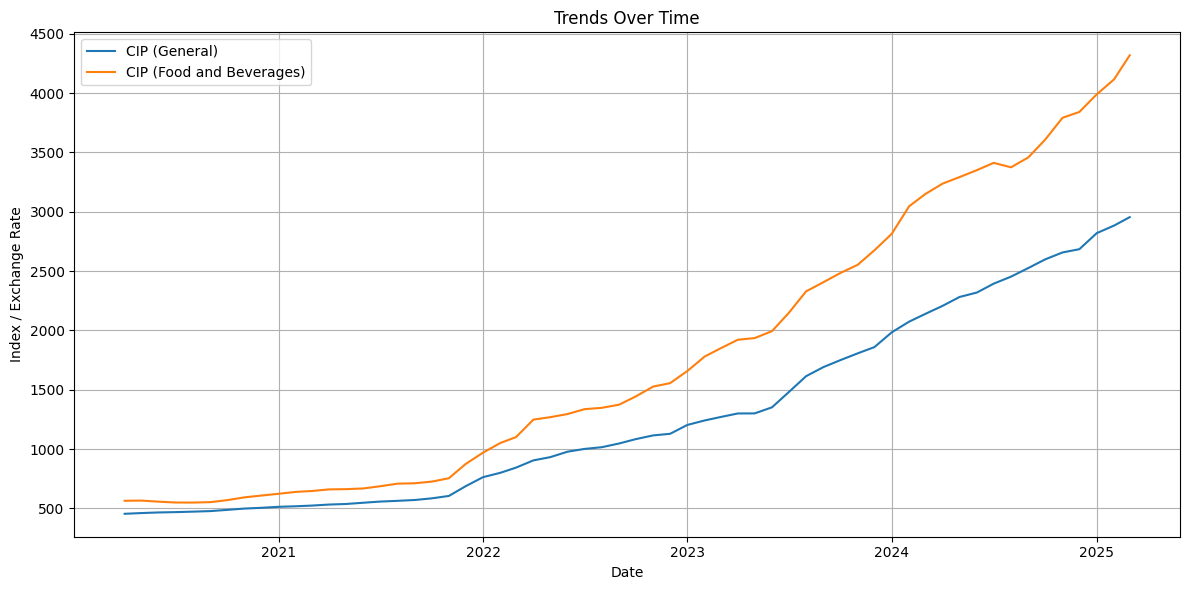

In [45]:
# Plot trends
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CIP_general'], label='CIP (General)')
plt.plot(df.index, df['CIP_food'], label='CIP (Food and Beverages)')
plt.title('Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Index / Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

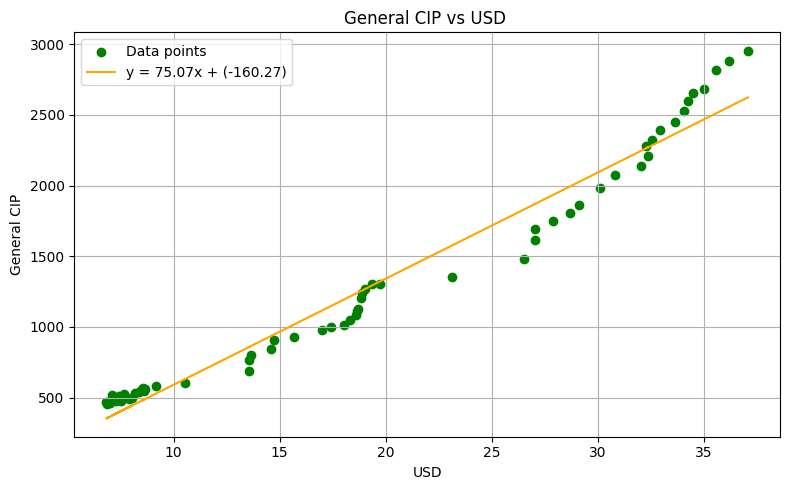

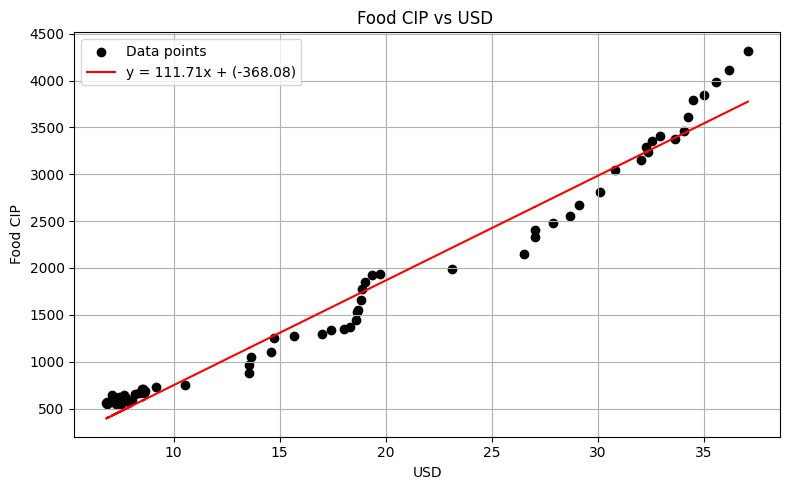

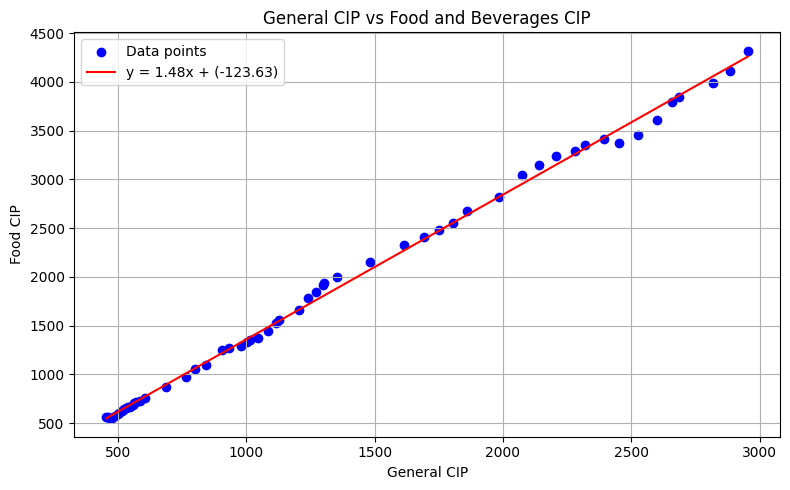

In [46]:
# Function that helps to print scatterplot and regression line in the same graph
def scatter_with_regression(x, y, x_label, y_label, title, color_points, color_line):
    plt.figure(figsize=(8, 5))

    # Scatter plot
    plt.scatter(x, y, color=color_points, label="Data points")

    # Calculation of regression line
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color=color_line, label=f"y = {m:.2f}x + ({b:.2f})")

# Titles
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# General CIP vs USD
scatter_with_regression(
    df["usd"], df["CIP_general"],
    "USD", "General CIP",
    "General CIP vs USD ",
    color_points="green", color_line="orange"
)
# Food CIP vs USD
scatter_with_regression(
    df["usd"], df["CIP_food"],
    "USD", "Food CIP",
    "Food CIP vs USD ",
    color_points="black", color_line="red"
)

# General CIP vs Food and Beverages CIP
scatter_with_regression(
    df["CIP_general"], df["CIP_food"],
    "General CIP", "Food CIP",
    "General CIP vs Food and Beverages CIP",
    color_points="blue", color_line="red"
)

# **Regression and Correlation Analysis**

In [47]:
# Regression analysis for USD and Food CIP
X = df['usd']
y = df['CIP_food']
X = sm.add_constant(X)  # Add constant to predictor
model = sm.OLS(y, X).fit()

#Pearson Correlation Test
correlation, p_value_usd_food = pearsonr(df['usd'], df['CIP_food'])
print("Correlation:", correlation)
print("P-Value:", p_value_usd_food)

if p_value_usd_food < 0.05:
    print("Significant relationship.")
    print()
else:
    print(" No significant relationship.")
    print()

# Regression analysis for USD and General CIP
X = df['usd']
y = df['CIP_general']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

#Pearson Correlation Test
correlation, p_value_usd_general = pearsonr(df['usd'], df['CIP_general'])
print("Correlation:", correlation)
print("P-Value:", p_value_usd_general)

if p_value_usd_general < 0.05:
    print("Significant relationship.")
    print()
else:
    print("No significant relationship.")
    print()

Correlation: 0.9848091713601699
P-Value: 8.403957146333189e-46
Significant relationship.

Correlation: 0.9828703882008641
P-Value: 2.665737615471828e-44
Significant relationship.



# **Hypothesis Testing**


In [49]:
if p_value_usd_food < 0.05 and p_value_usd_general < 0.05:
    print("Final Conclusion: We fail to reject the null hypothesis (H₀).")
    print("Exchange rates have a statistically significant effect on grocery prices in Turkey.")
else:
    print("Final Conclusion: We reject the null hypothesis (H₀).")
    print("Exchange rates do not have a statistically significant effect on grocery prices.")

Final Conclusion: We fail to reject the null hypothesis (H₀).
Exchange rates have a statistically significant effect on grocery prices in Turkey.
